In [31]:
import os
import glob
import numpy as np
import SimpleITK as sitk
from PIL import Image
from tqdm import tqdm # Barra de progreso

# --- CONFIGURACIÓN ---
# Ruta donde están tus .mha AHORA (según tu foto)
source_folder = r'E:\Dataset\dataset_node21\cxr_images\proccessed_data\images'

# Ruta donde quieres guardar los PNGs NUEVOS
target_folder = r'E:\Dataset\dataset_node21\images_png_ready'

# Crear la carpeta destino si no existe
os.makedirs(target_folder, exist_ok=True)

print(f"🔄 Iniciando conversión...")
print(f"📂 Origen: {source_folder}")
print(f"📂 Destino: {target_folder}")

# Buscar todos los archivos .mha
mha_files = glob.glob(os.path.join(source_folder, "*.mha"))
print(f"📄 Se han encontrado {len(mha_files)} archivos .mha")

# Bucle de conversión
for mha_path in tqdm(mha_files):
    try:
        # 1. Leer imagen médica
        image = sitk.ReadImage(mha_path)
        img_array = sitk.GetArrayFromImage(image)

        # 2. Quitar dimensiones extra (A veces vienen como [1, Alto, Ancho])
        if len(img_array.shape) == 3:
            img_array = img_array[0]

        # 3. NORMALIZACIÓN IMPORTANTE
        # Las imágenes médicas tienen rangos raros. Las pasamos a 0-255.
        img_array = img_array.astype(float)
        min_val = img_array.min()
        max_val = img_array.max()

        if max_val != min_val: # Evitar división por cero en imágenes negras
            img_array = (img_array - min_val) / (max_val - min_val) * 255.0

        img_array = img_array.astype(np.uint8)

        # 4. Guardar como PNG
        final_image = Image.fromarray(img_array)

        # Obtenemos solo el nombre (ej: "c1505.mha") y cambiamos extensión
        filename = os.path.basename(mha_path).replace('.mha', '.png')
        save_path = os.path.join(target_folder, filename)

        final_image.save(save_path)

    except Exception as e:
        print(f"❌ Error convirtiendo {mha_path}: {e}")

print("✅ ¡Conversión terminada! Ahora revisa tu carpeta 'images_png_ready'")

🔄 Iniciando conversión...
📂 Origen: E:\Dataset\dataset_node21\cxr_images\proccessed_data\images
📂 Destino: E:\Dataset\dataset_node21\images_png_ready
📄 Se han encontrado 4882 archivos .mha


100%|██████████| 4882/4882 [03:27<00:00, 23.53it/s]

✅ ¡Conversión terminada! Ahora revisa tu carpeta 'images_png_ready'


In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# --- 1. CONFIGURACIÓN ---
base_dir = r'E:\Dataset\dataset_node21\cxr_images\proccessed_data'
csv_path = os.path.join(base_dir, 'metadata.csv')
png_folder = r'E:\Dataset\dataset_node21\images_png_ready'

IMG_SIZE = (224, 224)

# Mantenemos 64 para aprovechar la GPU al máximo, ya que la CPU irá sola
BATCH_SIZE = 64

# CAMBIO OBLIGATORIO PARA WINDOWS + NOTEBOOK:
NUM_WORKERS = 0

# --- 2. PREPARAR EL DATAFRAME ---
df = pd.read_csv(csv_path)
col_filename = 'img_name'
col_label = 'label'

df[col_filename] = df[col_filename].astype(str).str.replace('.mha', '.png')
df[col_label] = df[col_label].astype(int)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[col_label])

print(f"✅ Configuración cargada (Batch: {BATCH_SIZE}, Workers: {NUM_WORKERS}).")

# --- 3. TRANSFORMACIONES ---
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# --- 4. DATASET ---
class Node21Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filename = self.dataframe.iloc[idx][col_filename]
        label = self.dataframe.iloc[idx][col_label]
        img_path = os.path.join(self.root_dir, filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            image = Image.new('RGB', IMG_SIZE)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# --- 5. GENERADORES (Safe Mode) ---
train_dataset = Node21Dataset(train_df, png_folder, transform=train_transforms)
val_dataset = Node21Dataset(val_df, png_folder, transform=val_transforms)
# Al poner workers=0, quitamos 'persistent_workers' porque daría error
train_ds = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      # Obligatorio en Windows Notebooks
    pin_memory=True     # Esto SÍ ayuda a pasar rápido a la GPU
)

val_ds = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\n--- ¡DataLoaders Listos (Modo Seguro Windows)! ---")

# Verificación
try:
    batch_imgs, batch_labels = next(iter(train_ds))
    print(f"✅ ÉXITO: Batch cargado con forma {batch_imgs.shape}")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Configuración cargada (Batch: 64, Workers: 0).

--- ¡DataLoaders Listos (Modo Seguro Windows)! ---
✅ ÉXITO: Batch cargado con forma torch.Size([64, 3, 224, 224])


In [41]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from tqdm.auto import tqdm

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Usando dispositivo: {device}")

# --- CLASES AUXILIARES ---
class EarlyStoppingPyTorch:
    def __init__(self, patience=5, path='mejor_vgg_node21.pth', verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'   ⏳ EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'   💾 Guardando modelo (Loss bajó: {self.val_loss_min:.6f} --> {val_loss:.6f})')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class MiVGG16(nn.Module):
    def __init__(self):
        super(MiVGG16, self).__init__()
        self.vgg = models.vgg16(weights=None)
        self.vgg.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.vgg(x)

# Inicializar
model = MiVGG16().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
early_stopping = EarlyStoppingPyTorch(patience=5, verbose=True)

# --- LISTAS PARA GUARDAR EL HISTORIAL (AHORA CON TRAIN ACC) ---
history = {
    'train_loss': [],
    'train_acc': [],  # <--- NUEVO
    'val_loss': [],
    'val_acc': []
}

# --- BUCLE DE ENTRENAMIENTO ---
epochs = 30
print("\n🏁 INICIANDO ENTRENAMIENTO...")

for epoch in range(epochs):

    # --- 1. TRAIN ---
    model.train()
    running_loss = 0.0
    train_correct = 0  # <--- NUEVO: Contador de aciertos train
    train_total = 0    # <--- NUEVO: Contador total train

    loop = tqdm(train_ds, total=len(train_ds), leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # --- CALCULAR ACCURACY EN TRAIN (NUEVO) ---
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels.view(-1, 1)).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_ds.dataset)
    epoch_train_acc = train_correct / train_total # <--- NUEVO

    # --- 2. VALIDATION ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels.view(-1, 1)).sum().item()

    epoch_val_loss = val_loss / len(val_ds.dataset)
    epoch_val_acc = val_correct / val_total

    # --- GUARDAR TODO EN EL HISTORIAL ---
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_train_acc) # <--- GUARDAMOS TRAIN ACC
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f'   Epoch {epoch+1}: '
          f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | ' # Mostramos en pantalla
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    # --- 3. CHECK EARLY STOPPING ---
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("🛑 Early Stopping activado.")
        break

print("✅ Entrenamiento finalizado.")

# --- RECUPERAR EL MEJOR MODELO ---
model.load_state_dict(torch.load('mejor_vgg_node21.pth', weights_only=True))

print("🏆 Modelo con mejores pesos cargado (Sin warnings).")

🚀 Usando dispositivo: cuda

🏁 INICIANDO ENTRENAMIENTO...


Epoch [1/30]: 100%|██████████| 66/66 [01:48<00:00,  1.65s/it, loss=0.596]


   Epoch 1: Train Loss: 0.6138 | Train Acc: 0.7114 | Val Loss: 0.6148 | Val Acc: 0.7177
   💾 Guardando modelo (Loss bajó: inf --> 0.614840)


Epoch [2/30]: 100%|██████████| 66/66 [01:40<00:00,  1.52s/it, loss=0.544]


   Epoch 2: Train Loss: 0.5927 | Train Acc: 0.7174 | Val Loss: 0.5748 | Val Acc: 0.7177
   💾 Guardando modelo (Loss bajó: 0.614840 --> 0.574839)


Epoch [3/30]: 100%|██████████| 66/66 [01:42<00:00,  1.56s/it, loss=0.599]


   Epoch 3: Train Loss: 0.5735 | Train Acc: 0.7174 | Val Loss: 0.5834 | Val Acc: 0.7177
   ⏳ EarlyStopping: 1/5


Epoch [4/30]: 100%|██████████| 66/66 [01:39<00:00,  1.52s/it, loss=0.452]


   Epoch 4: Train Loss: 0.5612 | Train Acc: 0.7174 | Val Loss: 0.5420 | Val Acc: 0.7177
   💾 Guardando modelo (Loss bajó: 0.574839 --> 0.542046)


Epoch [5/30]: 100%|██████████| 66/66 [01:40<00:00,  1.52s/it, loss=0.618]


   Epoch 5: Train Loss: 0.5390 | Train Acc: 0.7176 | Val Loss: 0.5912 | Val Acc: 0.6660
   ⏳ EarlyStopping: 1/5


Epoch [6/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.566]


   Epoch 6: Train Loss: 0.5462 | Train Acc: 0.7219 | Val Loss: 0.5397 | Val Acc: 0.7177
   💾 Guardando modelo (Loss bajó: 0.542046 --> 0.539687)


Epoch [7/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.651]


   Epoch 7: Train Loss: 0.5314 | Train Acc: 0.7176 | Val Loss: 0.5668 | Val Acc: 0.6928
   ⏳ EarlyStopping: 1/5


Epoch [8/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.47] 


   Epoch 8: Train Loss: 0.5226 | Train Acc: 0.7234 | Val Loss: 0.5053 | Val Acc: 0.7043
   💾 Guardando modelo (Loss bajó: 0.539687 --> 0.505253)


Epoch [9/30]: 100%|██████████| 66/66 [01:43<00:00,  1.56s/it, loss=0.824]


   Epoch 9: Train Loss: 0.5015 | Train Acc: 0.7310 | Val Loss: 0.5237 | Val Acc: 0.7081
   ⏳ EarlyStopping: 1/5


Epoch [10/30]: 100%|██████████| 66/66 [01:40<00:00,  1.52s/it, loss=0.452]


   Epoch 10: Train Loss: 0.5139 | Train Acc: 0.7267 | Val Loss: 0.5113 | Val Acc: 0.7282
   ⏳ EarlyStopping: 2/5


Epoch [11/30]: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it, loss=0.441]


   Epoch 11: Train Loss: 0.5037 | Train Acc: 0.7365 | Val Loss: 0.4896 | Val Acc: 0.7359
   💾 Guardando modelo (Loss bajó: 0.505253 --> 0.489602)


Epoch [12/30]: 100%|██████████| 66/66 [01:47<00:00,  1.64s/it, loss=0.458]


   Epoch 12: Train Loss: 0.4819 | Train Acc: 0.7586 | Val Loss: 0.4564 | Val Acc: 0.7770
   💾 Guardando modelo (Loss bajó: 0.489602 --> 0.456403)


Epoch [13/30]: 100%|██████████| 66/66 [01:47<00:00,  1.64s/it, loss=0.495]


   Epoch 13: Train Loss: 0.4711 | Train Acc: 0.7698 | Val Loss: 0.4737 | Val Acc: 0.7416
   ⏳ EarlyStopping: 1/5


Epoch [14/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.39] 


   Epoch 14: Train Loss: 0.4602 | Train Acc: 0.7810 | Val Loss: 0.4233 | Val Acc: 0.8038
   💾 Guardando modelo (Loss bajó: 0.456403 --> 0.423335)


Epoch [15/30]: 100%|██████████| 66/66 [01:47<00:00,  1.64s/it, loss=0.34] 


   Epoch 15: Train Loss: 0.4277 | Train Acc: 0.8002 | Val Loss: 0.3829 | Val Acc: 0.8287
   💾 Guardando modelo (Loss bajó: 0.423335 --> 0.382874)


Epoch [16/30]: 100%|██████████| 66/66 [01:48<00:00,  1.64s/it, loss=0.196]


   Epoch 16: Train Loss: 0.3699 | Train Acc: 0.8368 | Val Loss: 0.8302 | Val Acc: 0.7560
   ⏳ EarlyStopping: 1/5


Epoch [17/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.155]


   Epoch 17: Train Loss: 0.3524 | Train Acc: 0.8411 | Val Loss: 0.3714 | Val Acc: 0.8057
   💾 Guardando modelo (Loss bajó: 0.382874 --> 0.371445)


Epoch [18/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.326]


   Epoch 18: Train Loss: 0.3065 | Train Acc: 0.8677 | Val Loss: 0.3143 | Val Acc: 0.8593
   💾 Guardando modelo (Loss bajó: 0.371445 --> 0.314258)


Epoch [19/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.129]


   Epoch 19: Train Loss: 0.2720 | Train Acc: 0.8914 | Val Loss: 0.2135 | Val Acc: 0.9129
   💾 Guardando modelo (Loss bajó: 0.314258 --> 0.213471)


Epoch [20/30]: 100%|██████████| 66/66 [01:47<00:00,  1.64s/it, loss=0.193] 


   Epoch 20: Train Loss: 0.2637 | Train Acc: 0.8971 | Val Loss: 0.1914 | Val Acc: 0.9263
   💾 Guardando modelo (Loss bajó: 0.213471 --> 0.191393)


Epoch [21/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.234] 


   Epoch 21: Train Loss: 0.2610 | Train Acc: 0.8945 | Val Loss: 0.3228 | Val Acc: 0.8995
   ⏳ EarlyStopping: 1/5


Epoch [22/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.152] 


   Epoch 22: Train Loss: 0.2216 | Train Acc: 0.9201 | Val Loss: 0.5032 | Val Acc: 0.8019
   ⏳ EarlyStopping: 2/5


Epoch [23/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.344] 


   Epoch 23: Train Loss: 0.1777 | Train Acc: 0.9344 | Val Loss: 0.1335 | Val Acc: 0.9464
   💾 Guardando modelo (Loss bajó: 0.191393 --> 0.133541)


Epoch [24/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.0796]


   Epoch 24: Train Loss: 0.1671 | Train Acc: 0.9354 | Val Loss: 0.1137 | Val Acc: 0.9560
   💾 Guardando modelo (Loss bajó: 0.133541 --> 0.113726)


Epoch [25/30]: 100%|██████████| 66/66 [01:54<00:00,  1.73s/it, loss=0.176] 


   Epoch 25: Train Loss: 0.1606 | Train Acc: 0.9352 | Val Loss: 0.1166 | Val Acc: 0.9598
   ⏳ EarlyStopping: 1/5


Epoch [26/30]: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it, loss=0.104] 


   Epoch 26: Train Loss: 0.1840 | Train Acc: 0.9270 | Val Loss: 0.4692 | Val Acc: 0.7856
   ⏳ EarlyStopping: 2/5


Epoch [27/30]: 100%|██████████| 66/66 [01:51<00:00,  1.69s/it, loss=0.205] 


   Epoch 27: Train Loss: 0.1464 | Train Acc: 0.9466 | Val Loss: 0.2092 | Val Acc: 0.9206
   ⏳ EarlyStopping: 3/5


Epoch [28/30]: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it, loss=0.0912]


   Epoch 28: Train Loss: 0.1304 | Train Acc: 0.9509 | Val Loss: 0.1821 | Val Acc: 0.9282
   ⏳ EarlyStopping: 4/5


Epoch [29/30]: 100%|██████████| 66/66 [01:50<00:00,  1.67s/it, loss=0.0506]


   Epoch 29: Train Loss: 0.1430 | Train Acc: 0.9466 | Val Loss: 0.5504 | Val Acc: 0.8344
   ⏳ EarlyStopping: 5/5
🛑 Early Stopping activado.
✅ Entrenamiento finalizado.


C:\Users\Toni\AppData\Local\Temp\ipykernel_3492\89473493.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mejor_vgg_node21.pth'))


🏆 Modelo con mejores pesos cargado.


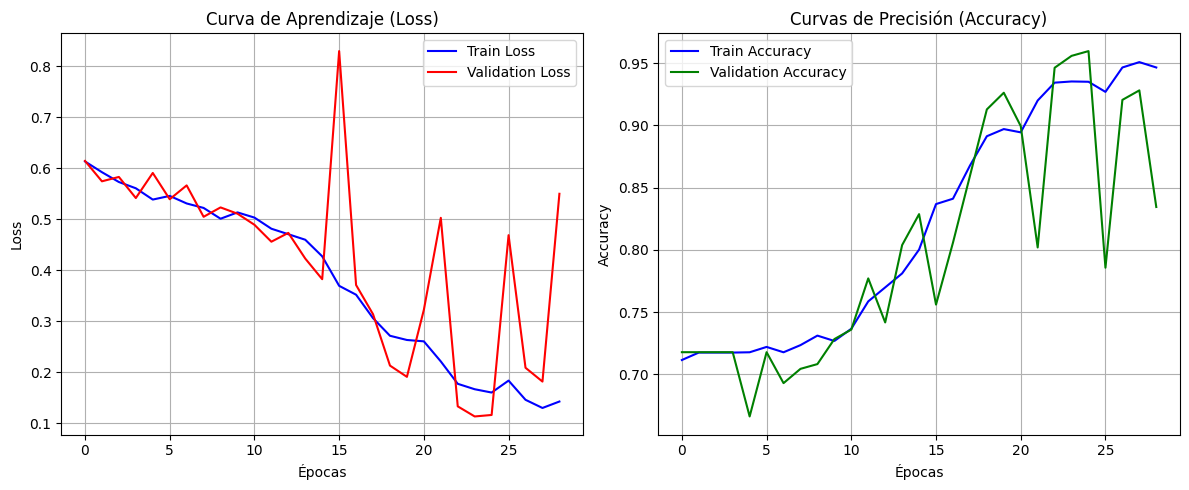

In [42]:
import matplotlib.pyplot as plt

# Crear una figura con dos gráficas (Loss y Accuracy)
plt.figure(figsize=(12, 5))

# --- GRÁFICA 1: PÉRDIDA (LOSS) ---
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.title('Curva de Aprendizaje (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- GRÁFICA 2: PRECISIÓN (ACCURACY) ---
plt.subplot(1, 2, 2)
# AHORA SÍ pintamos ambas curvas
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')   # <--- NUEVA LÍNEA
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Curvas de Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

📊 Cargando metadatos para verificar aciertos...

🕵️‍♂️ Auditando al modelo con 5 casos aleatorios...


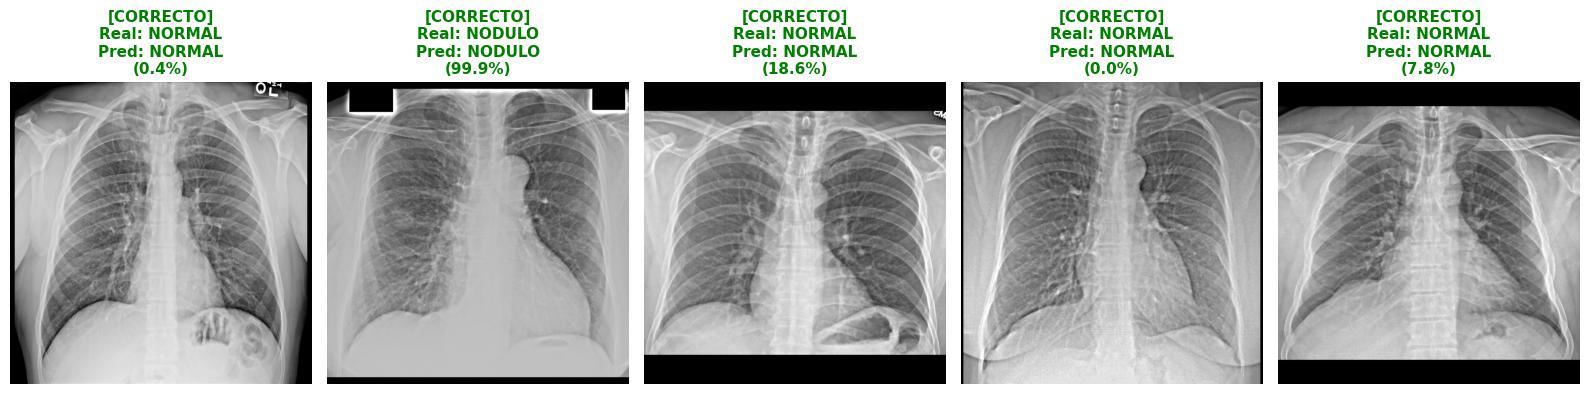

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN ---
base_dir = r'E:\Dataset\dataset_node21\cxr_images\proccessed_data'
png_folder = r'E:\Dataset\dataset_node21\images_png_ready'
csv_path = os.path.join(base_dir, 'metadata.csv')
model_path = 'mejor_vgg_node21.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. CARGAR CSV DE ETIQUETAS REALES ---
print("📊 Cargando metadatos para verificar aciertos...")
df = pd.read_csv(csv_path)
# Limpiamos nombres para que coincidan (quitamos .mha, ponemos .png)
df['img_name'] = df['img_name'].astype(str).str.replace('.mha', '.png')
# Creamos un diccionario rápido: {'archivo.png': 1, 'otro.png': 0}
etiquetas_reales = dict(zip(df['img_name'], df['label']))

# --- 3. ARQUITECTURA DEL MODELO ---
class MiVGG16(nn.Module):
    def __init__(self):
        super(MiVGG16, self).__init__()
        self.vgg = models.vgg16(weights=None)
        self.vgg.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.vgg(x)

# --- 4. CARGAR MODELO ---
model = MiVGG16().to(device)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

# --- 5. FUNCIÓN DE PREDICCIÓN ---
pred_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def evaluar_imagen(filename):
    path = os.path.join(png_folder, filename)

    # 1. Obtener Realidad
    # Si el archivo no está en el CSV, asumimos desconocido (-1)
    clase_real = etiquetas_reales.get(filename, -1)

    # 2. Obtener Predicción
    image = Image.open(path).convert('RGB')
    img_tensor = pred_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        prob = output.item()

    clase_predicha = 1 if prob > 0.5 else 0

    return image, clase_real, clase_predicha, prob

# --- 6. VISUALIZACIÓN DE ACIERTOS/FALLOS (VERSIÓN SIN EMOJIS) ---
print("\n🕵️‍♂️ Auditando al modelo con 5 casos aleatorios...")

all_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]
# Protección por si hay pocos archivos
num_muestras = min(5, len(all_files))
random_files = random.sample(all_files, num_muestras)

plt.figure(figsize=(16, 6))

for i, filename in enumerate(random_files):
    img, real, pred, prob = evaluar_imagen(filename)

    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Textos
    txt_real = "NODULO" if real == 1 else "NORMAL"
    txt_pred = "NODULO" if pred == 1 else "NORMAL"

    # Lógica de colores y TEXTO SIMPLE
    if real == pred:
        color_titulo = 'green'
        resultado = "[CORRECTO]" # Cambiado ✅ por texto
    else:
        color_titulo = 'red'
        resultado = "[FALLO]"    # Cambiado ❌ por texto

    titulo = f"{resultado}\nReal: {txt_real}\nPred: {txt_pred}\n({prob:.1%})"
    plt.title(titulo, color=color_titulo, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

#ResNet#


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Usando dispositivo: {device}")

# --- 1. CLASES AUXILIARES (Early Stopping) ---
class EarlyStoppingPyTorch:
    def __init__(self, patience=5, path='mejor_resnet_node21.pth', verbose=False): # OJO: Cambié el nombre del archivo
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'   ⏳ EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'   💾 Guardando modelo (Loss bajó: {self.val_loss_min:.6f} --> {val_loss:.6f})')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- 2. DEFINICIÓN DEL MODELO RESNET (EL CAMBIO IMPORTANTE) ---
class MiResNet18(nn.Module):
    def __init__(self):
        super(MiResNet18, self).__init__()

        # A. TRANSFER LEARNING REAL: Cargamos pesos pre-entrenados
        # Esto descarga los "conocimientos" previos de ImageNet
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # B. CONGELAR CAPAS
        #for param in self.resnet.parameters():
        #    param.requires_grad = False

        # C. CAMBIAR LA ÚLTIMA CAPA
        # ResNet18 tiene 512 entradas en su última capa (.fc)
        num_ftrs = self.resnet.fc.in_features

        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1), # De 512 a 1 salida
            nn.Sigmoid()            # Para probabilidad 0-1
        )

    def forward(self, x):
        return self.resnet(x)



🚀 Usando dispositivo: cuda


In [56]:
# --- 3. INICIALIZACIÓN ---
model = MiResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


early_stopping = EarlyStoppingPyTorch(patience=5, path='mejor_resnet_node21.pth', verbose=True)

# Historial
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}



In [57]:
# --- 4. BUCLE DE ENTRENAMIENTO (CORREGIDO) ---
epochs = 30
print("\n🏁 INICIANDO TRANSFER LEARNING CON RESNET18...")

for epoch in range(epochs):
    # TRAIN
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    loop = tqdm(train_ds, total=len(train_ds), leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels.view(-1, 1)).sum().item()

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_ds.dataset)
    epoch_train_acc = train_correct / train_total

    # VALIDATION
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels.view(-1, 1)).sum().item()

    epoch_val_loss = val_loss / len(val_ds.dataset)
    epoch_val_acc = val_correct / val_total

    # Guardar historial
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    # --- AQUI ESTÁ EL CAMBIO: AÑADIDO TRAIN ACC AL PRINT ---
    print(f'   Epoch {epoch+1}: '
          f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    # Actualizar Scheduler (Sin verbose para evitar warnings)
    scheduler.step(epoch_val_loss)

    # Early Stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("🛑 Early Stopping activado.")
        break

print("✅ Entrenamiento finalizado.")

# Recuperar el mejor modelo (Usando weights_only=True)
model.load_state_dict(torch.load('mejor_resnet_node21.pth', weights_only=True))
print("🏆 Mejor modelo ResNet cargado.")


🏁 INICIANDO TRANSFER LEARNING CON RESNET18...


Epoch [1/30]: 100%|██████████| 66/66 [01:10<00:00,  1.08s/it, loss=0.234]


   Epoch 1: Train Loss: 0.3004 | Train Acc: 0.8741 | Val Loss: 2.6927 | Val Acc: 0.3330
   💾 Guardando modelo (Loss bajó: inf --> 2.692707)


Epoch [2/30]: 100%|██████████| 66/66 [01:02<00:00,  1.05it/s, loss=0.402] 


   Epoch 2: Train Loss: 0.1295 | Train Acc: 0.9517 | Val Loss: 0.1332 | Val Acc: 0.9378
   💾 Guardando modelo (Loss bajó: 2.692707 --> 0.133241)


Epoch [3/30]: 100%|██████████| 66/66 [01:03<00:00,  1.05it/s, loss=0.0376]


   Epoch 3: Train Loss: 0.0775 | Train Acc: 0.9734 | Val Loss: 0.3137 | Val Acc: 0.8833
   ⏳ EarlyStopping: 1/5


Epoch [4/30]: 100%|██████████| 66/66 [01:02<00:00,  1.05it/s, loss=0.00828]


   Epoch 4: Train Loss: 0.0519 | Train Acc: 0.9828 | Val Loss: 0.4309 | Val Acc: 0.8593
   ⏳ EarlyStopping: 2/5


Epoch [5/30]: 100%|██████████| 66/66 [01:02<00:00,  1.05it/s, loss=0.0438] 


   Epoch 5: Train Loss: 0.0411 | Train Acc: 0.9861 | Val Loss: 0.0550 | Val Acc: 0.9828
   💾 Guardando modelo (Loss bajó: 0.133241 --> 0.055004)


Epoch [6/30]: 100%|██████████| 66/66 [01:02<00:00,  1.05it/s, loss=0.0882] 


   Epoch 6: Train Loss: 0.0324 | Train Acc: 0.9880 | Val Loss: 0.8906 | Val Acc: 0.7885
   ⏳ EarlyStopping: 1/5


Epoch [7/30]: 100%|██████████| 66/66 [01:02<00:00,  1.06it/s, loss=0.014]  


   Epoch 7: Train Loss: 0.0313 | Train Acc: 0.9899 | Val Loss: 0.5562 | Val Acc: 0.8249
   ⏳ EarlyStopping: 2/5


Epoch [8/30]: 100%|██████████| 66/66 [01:03<00:00,  1.04it/s, loss=0.0034] 


   Epoch 8: Train Loss: 0.0302 | Train Acc: 0.9888 | Val Loss: 1.2834 | Val Acc: 0.7474
   ⏳ EarlyStopping: 3/5


Epoch [9/30]: 100%|██████████| 66/66 [01:09<00:00,  1.05s/it, loss=0.00565]


   Epoch 9: Train Loss: 0.0248 | Train Acc: 0.9914 | Val Loss: 0.4272 | Val Acc: 0.8833
   ⏳ EarlyStopping: 4/5


Epoch [10/30]: 100%|██████████| 66/66 [01:03<00:00,  1.05it/s, loss=0.00302] 


   Epoch 10: Train Loss: 0.0200 | Train Acc: 0.9938 | Val Loss: 0.0609 | Val Acc: 0.9789
   ⏳ EarlyStopping: 5/5
🛑 Early Stopping activado.
✅ Entrenamiento finalizado.
🏆 Mejor modelo ResNet cargado.


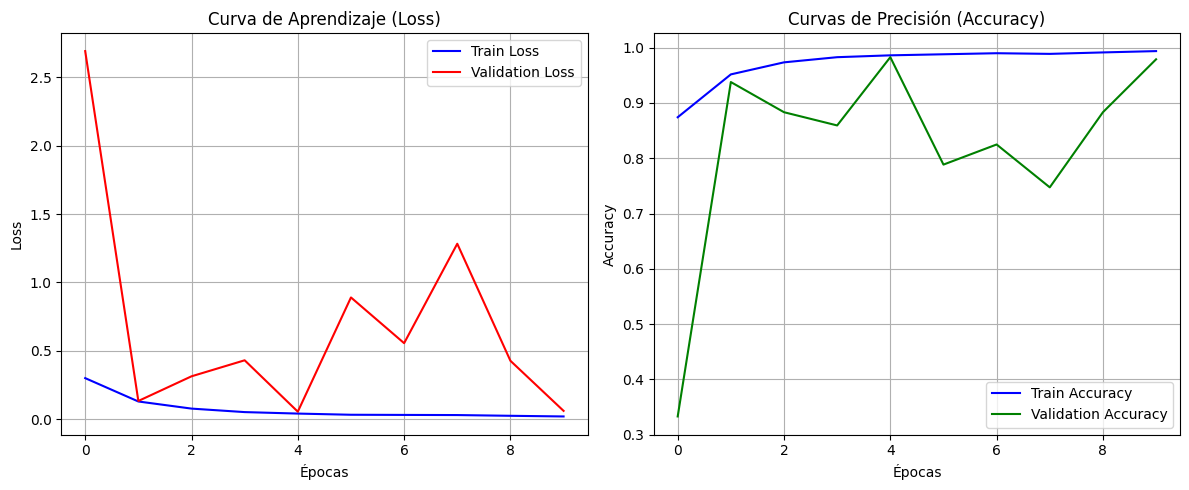

In [58]:
import matplotlib.pyplot as plt

# Crear una figura con dos gráficas (Loss y Accuracy)
plt.figure(figsize=(12, 5))

# --- GRÁFICA 1: PÉRDIDA (LOSS) ---
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.title('Curva de Aprendizaje (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- GRÁFICA 2: PRECISIÓN (ACCURACY) ---
plt.subplot(1, 2, 2)
# AHORA SÍ pintamos ambas curvas
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')   # <--- NUEVA LÍNEA
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Curvas de Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

YOLO


In [1]:
from ultralytics import YOLO
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
# 1. Cargar modelo (Usamos nano 'n' para velocidad máxima)
model = YOLO('yolov8n-cls.pt')

# 2. Entrenar
# IMPORTANTE: data debe apuntar a la carpeta NUEVA que acabamos de crear
results = model.train(
    data=r'E:\Dataset\dataset_node21\yolo_dataset_ready',
    epochs=30,
    imgsz=224,
    device=0,
    project='Proyecto_Yolo_Xray',
    name='entrenamiento_v1',
    batch=32,
    deterministic=False
)

# 3. Ver resultados
print("🚀 Entrenamiento finalizado.")

Ultralytics 8.3.245  Python-3.12.4 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:\Dataset\dataset_node21\yolo_dataset_ready, degrees=0.0, deterministic=False, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=entrenamiento_v14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

📊 Gráficas de Entrenamiento (Loss y Accuracy):


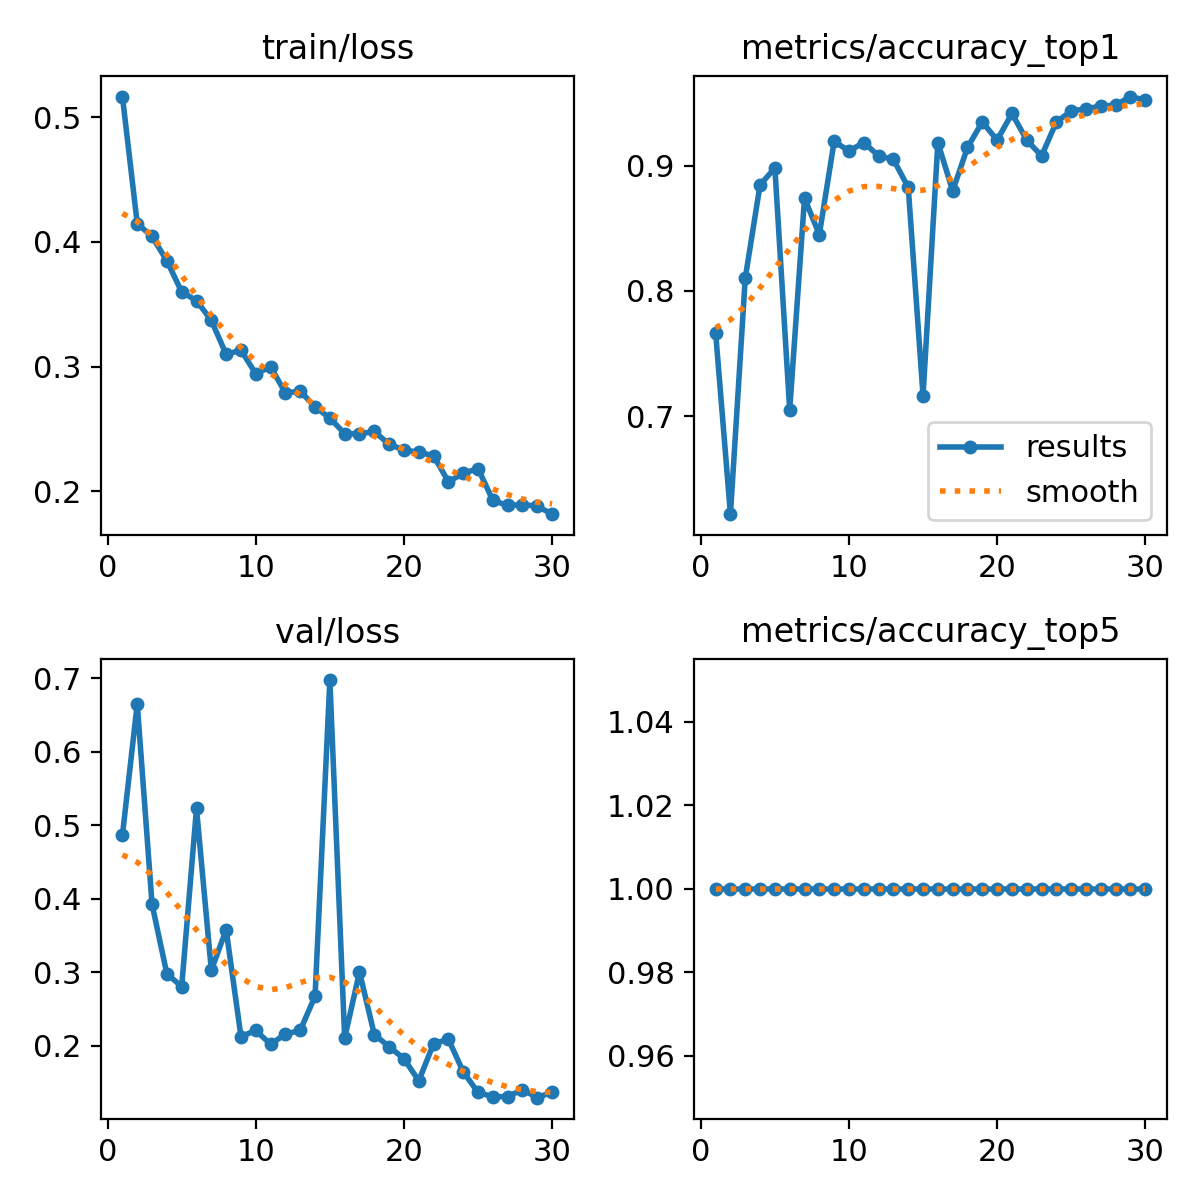

In [3]:
from IPython.display import Image, display
import os

# Ruta donde YOLO guardó tu entrenamiento
# Ajusta 'entrenamiento_v1' si usaste otro nombre o si YOLO creó 'entrenamiento_v12', etc.
ruta_resultados = os.path.join('Proyecto_Yolo_Xray', 'entrenamiento_v1', 'results.png')

print("📊 Gráficas de Entrenamiento (Loss y Accuracy):")
display(Image(filename=ruta_resultados))


😵 Matriz de Confusión (¿Dónde se equivoca?):


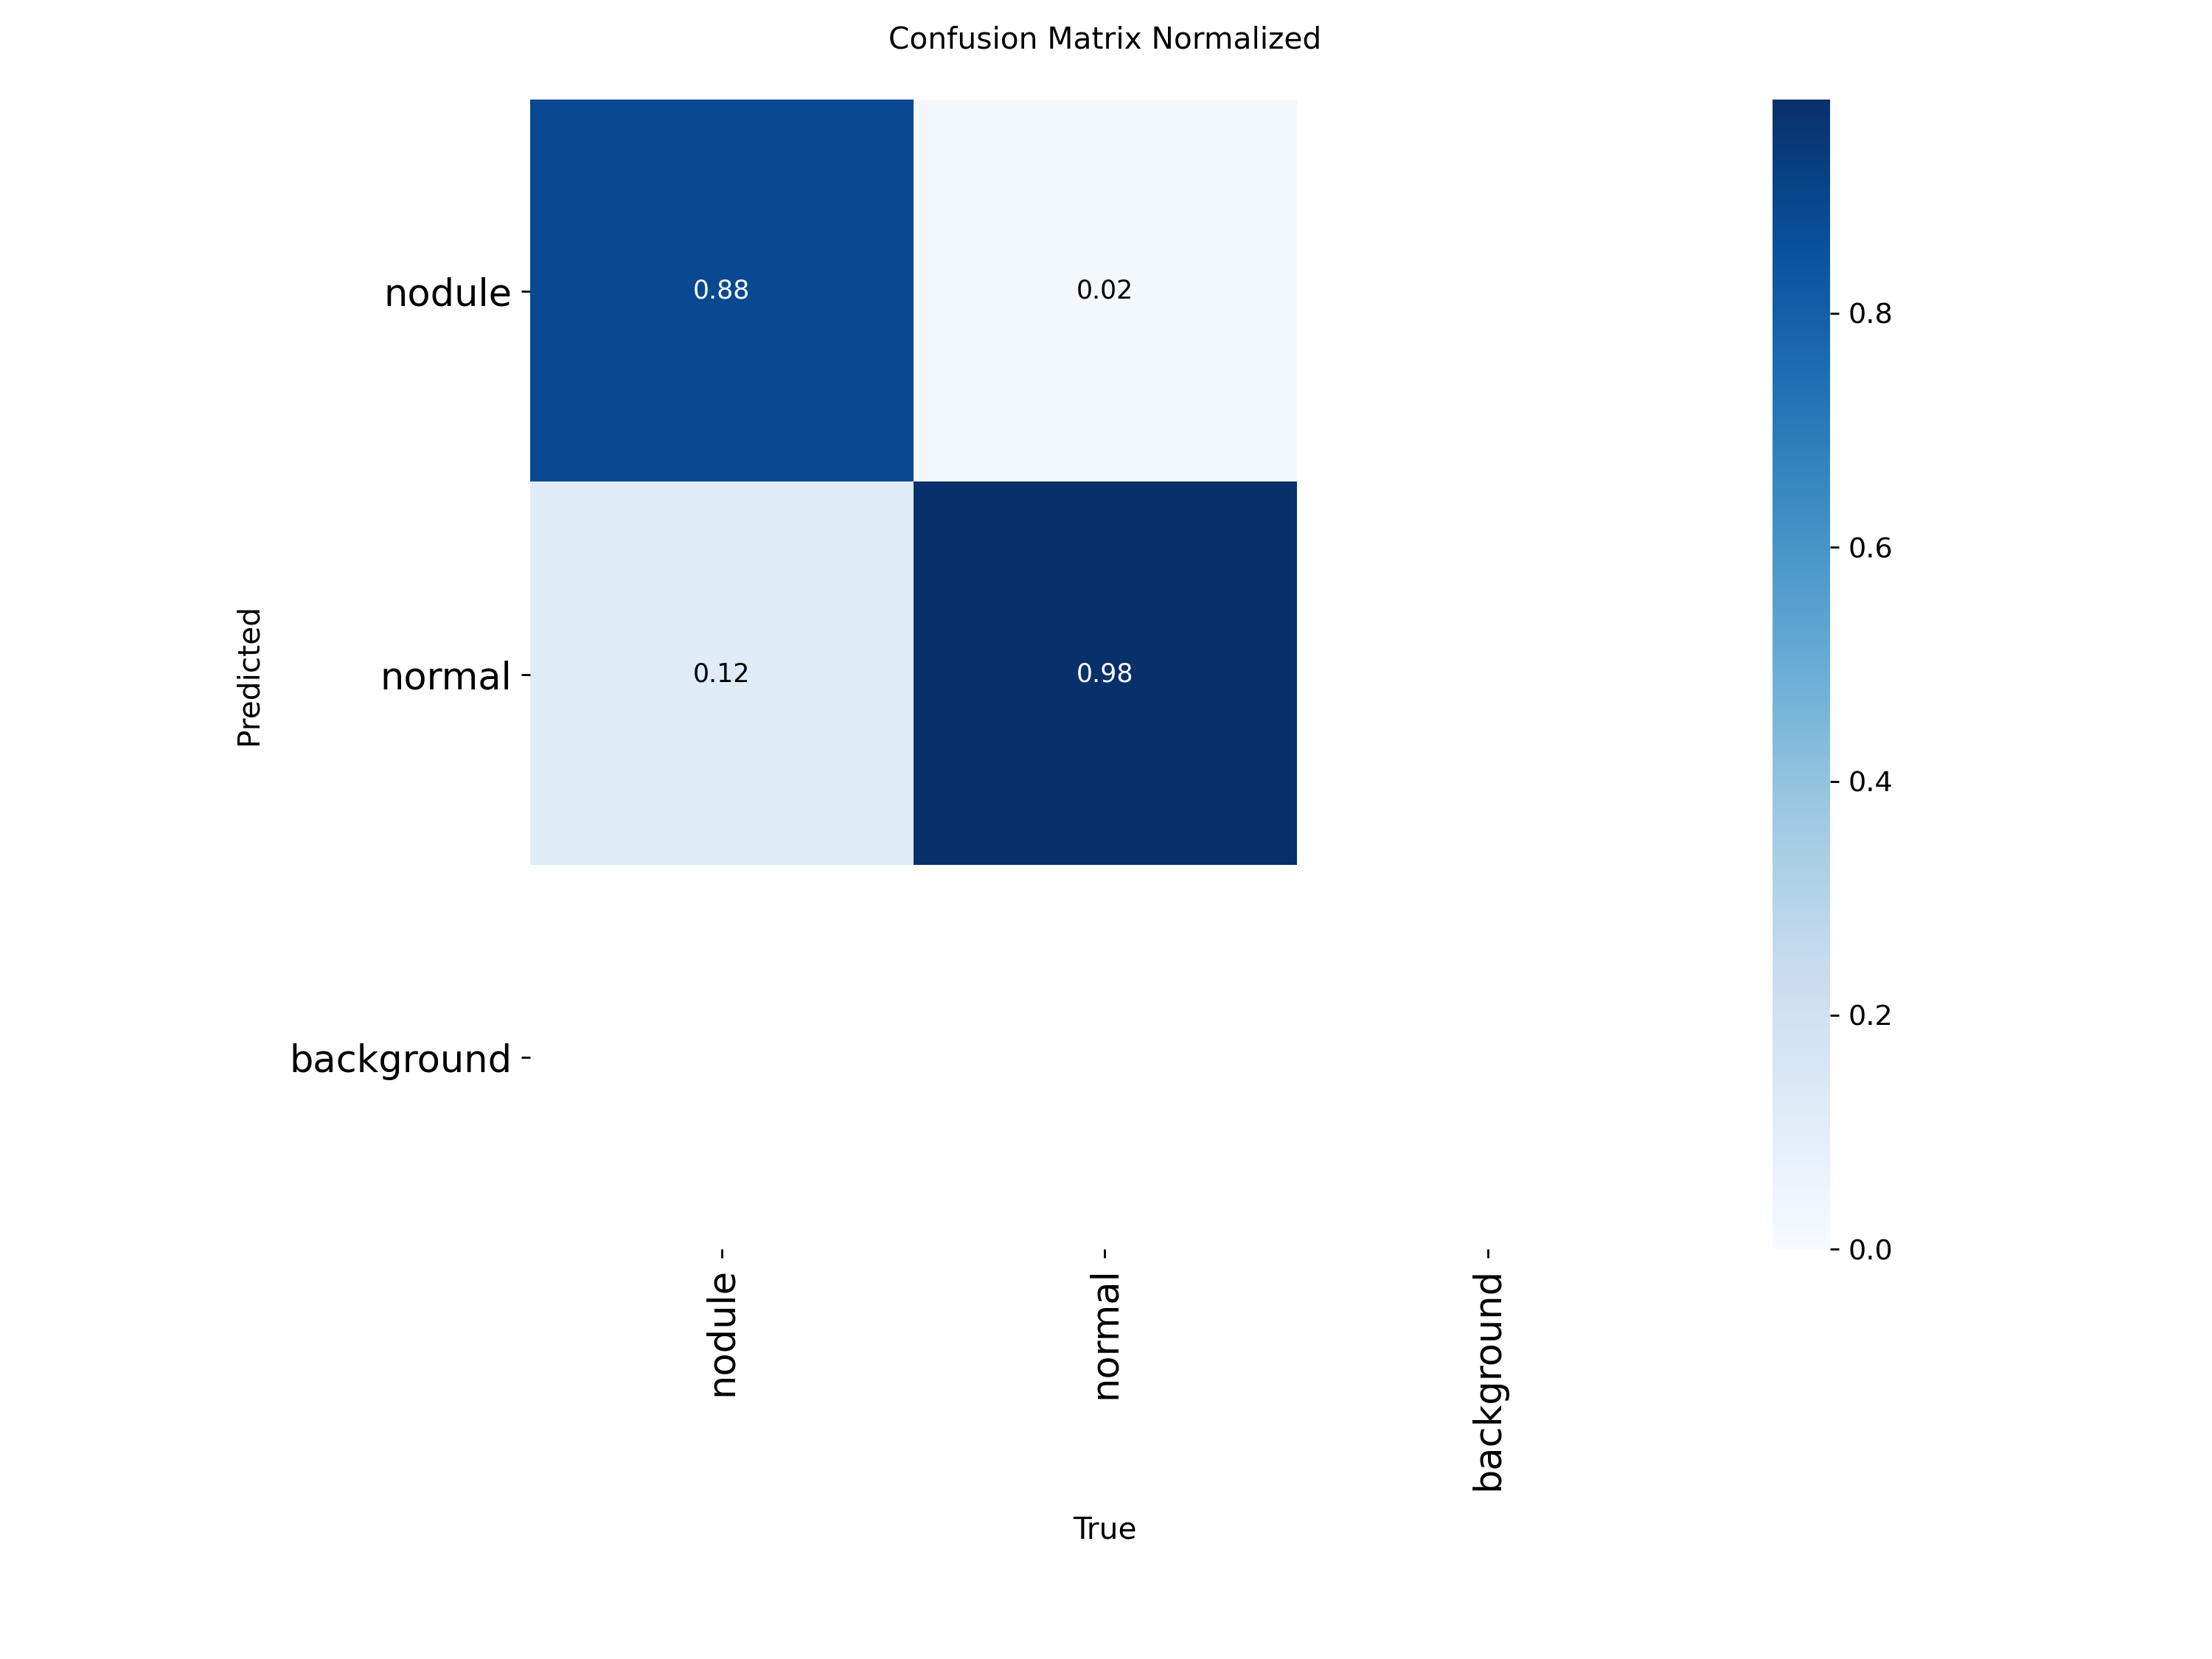

In [4]:
ruta_matriz = os.path.join('Proyecto_Yolo_Xray', 'entrenamiento_v1', 'confusion_matrix_normalized.png')

print("\n😵 Matriz de Confusión (¿Dónde se equivoca?):")
# A veces YOLO tarda un poco en generar este archivo si paraste el entreno antes.
# Si da error, prueba con 'confusion_matrix.png' sin _normalized
try:
    display(Image(filename=ruta_matriz))
except:
    print("⚠️ No se encontró la matriz normalizada, buscando la estándar...")
    ruta_matriz_std = os.path.join('Proyecto_Yolo_Xray', 'entrenamiento_v1', 'confusion_matrix.png')
    display(Image(filename=ruta_matriz_std))

🕵️‍♂️ Auditando 5 casos aleatorios...
✅ Gráfica generada. Mostrando resultado:


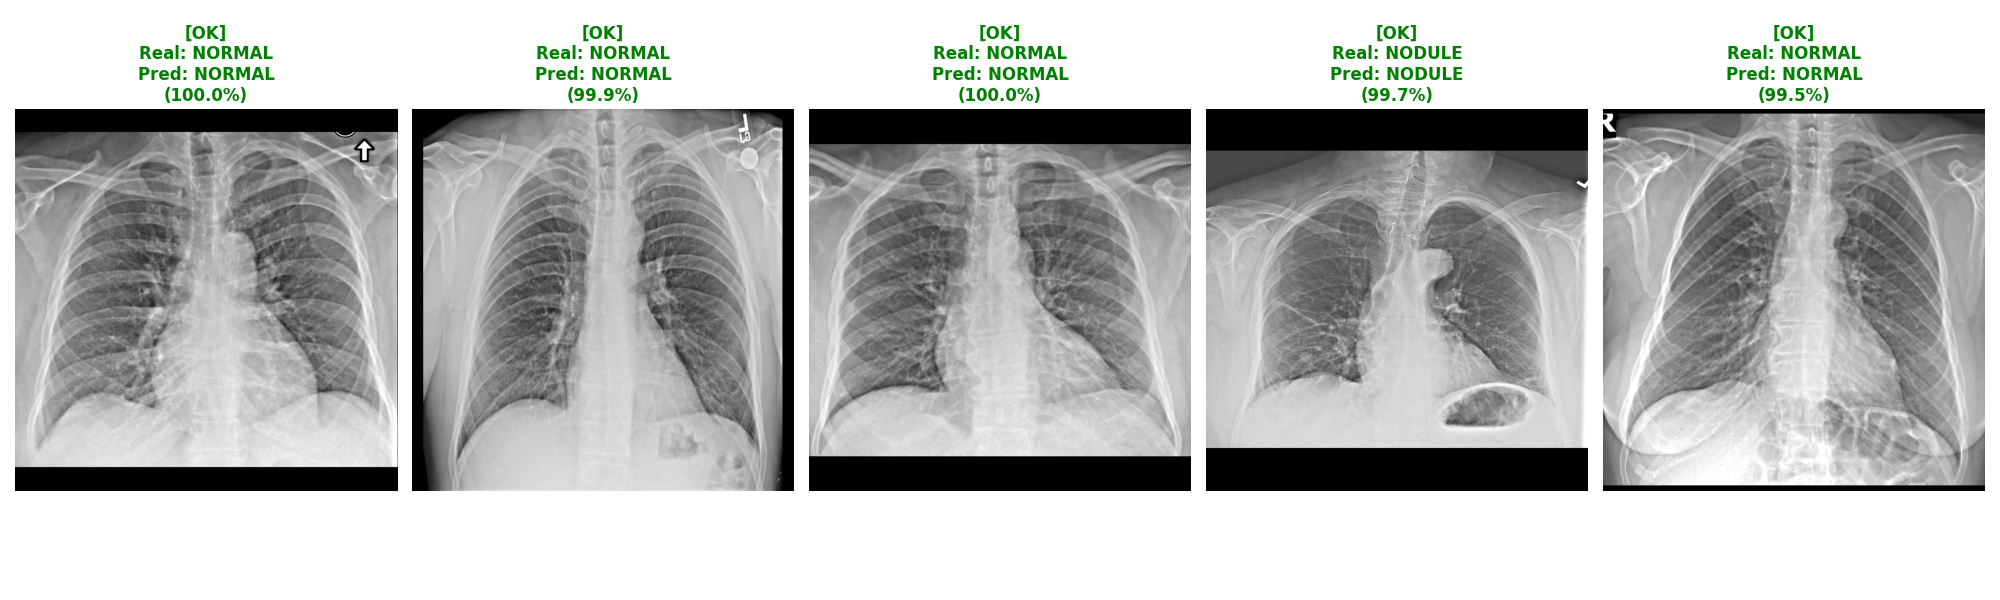

In [9]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Image, display

# --- CONFIGURACIÓN ---
ruta_modelo = r'Proyecto_Yolo_Xray/entrenamiento_v1/weights/best.pt'
val_dir = r'E:\Dataset\dataset_node21\yolo_dataset_ready\val'

# 1. Cargar modelo
model = YOLO(ruta_modelo)

# 2. Seleccionar imágenes
files_found = []
for folder in ['normal', 'nodule']:
    path = os.path.join(val_dir, folder)
    if os.path.exists(path):
        files_found += [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.png')]

if len(files_found) > 0:
    selected_files = random.sample(files_found, 5)

    # 3. Crear gráfica
    plt.figure(figsize=(20, 6))

    print(f"🕵️‍♂️ Auditando 5 casos aleatorios...")

    for i, file_path in enumerate(selected_files):
        # Leer imagen
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Predecir
        results = model(img, verbose=False)
        class_id = results[0].probs.top1
        class_name = results[0].names[class_id].upper()
        confianza = results[0].probs.data[class_id].item()

        # Etiquetas
        real_label = "NODULE" if "nodule" in file_path else "NORMAL"
        color = 'green' if real_label == class_name else 'red'
        texto_estado = "[OK]" if real_label == class_name else "[FALLO]"

        # Dibujar
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{texto_estado}\nReal: {real_label}\nPred: {class_name}\n({confianza:.1%})",
                  color=color, fontsize=12, fontweight='bold')

    plt.tight_layout()

    # --- EL TRUCO: GUARDAR Y MOSTRAR ---
    save_path = 'prediccion_final.png'
    plt.savefig(save_path)
    plt.close() # Cierra la figura para liberar memoria

    print("✅ Gráfica generada. Mostrando resultado:")
    display(Image(filename=save_path))

else:
    print("❌ No se encontraron imágenes.")

DenseNet

In [12]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Carregar el model pre-entrenat
# Fem servir "DEFAULT" per carregar els millors pesos disponibles
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# 2. Congelar pesos (Opcional, però recomanat inicialment)
# Com que ja has fet VGG des de 0, aquí pots fer Transfer Learning pur
for param in model.parameters():
    param.requires_grad = True

# 3. Modificar la capa final (Classificador)
# A DenseNet la capa final es diu 'classifier'
num_ftrs = model.classifier.in_features  # Sol ser 1024 en DenseNet121

model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.2),          # evitar overfitting
    nn.Linear(512, 1),        # Sortida binària (Nòdul vs Normal)
    nn.Sigmoid()
)

# 4. Moure a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ Model DenseNet-121 carregat i modificat per classificació binària.")

✅ Model DenseNet-121 carregat i modificat per classificació binària.


In [13]:
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np

# --- CONFIGURACIÓ ---
# 1. Funció de Pèrdua: BCELoss perquè la teva sortida és una Sigmoid (0 a 1)
criterion = nn.BCELoss()

# 2. Optimitzador: Només passem els paràmetres del classificador (la resta està congelada)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Historial per a les gràfiques
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0

# Nombre d'èpoques (al ser transfer learning, amb poques ja sol funcionar bé)
epochs = 30

print(f"🚀 Iniciant entrenament de DenseNet121 al dispositiu: {device}")
print("-" * 60)

for epoch in range(epochs):
    # --- FASE D'ENTRENAMENT ---
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Barra de progrés
    loop = tqdm(train_ds, total=len(train_ds), leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset de gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Càlcul de la pèrdua (Assegurar dimensions correctes)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backward pass i optimització
        loss.backward()
        optimizer.step()

        # Estadístiques
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels.view(-1, 1)).sum().item()

        # Actualitzar barra
        loop.set_postfix(loss=loss.item())

    # Càlcul mitjanes epoch
    epoch_train_loss = train_loss / len(train_ds.dataset)
    epoch_train_acc = train_correct / train_total

    # --- FASE DE VALIDACIÓ ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_ds:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))

            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels.view(-1, 1)).sum().item()

    epoch_val_loss = val_loss / len(val_ds.dataset)
    epoch_val_acc = val_correct / val_total

    # Guardar històric
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f'   Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
    print(f'   Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}')

    # Guardar el millor model
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), 'millor_densenet_node21.pth')
        print("   🏆 Model guardat (Millor Accuracy)")

    print("-" * 60)

print("✅ Entrenament finalitzat.")

🚀 Iniciant entrenament de DenseNet121 al dispositiu: cuda
------------------------------------------------------------


Epoch [1/30]: 100%|██████████| 66/66 [01:23<00:00,  1.26s/it, loss=0.311]


   Train Loss: 0.4392 | Train Acc: 0.7899
   Val Loss:   0.8598 | Val Acc:   0.5321
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [2/30]: 100%|██████████| 66/66 [01:21<00:00,  1.23s/it, loss=0.433]


   Train Loss: 0.3761 | Train Acc: 0.8277
   Val Loss:   0.4124 | Val Acc:   0.8163
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [3/30]: 100%|██████████| 66/66 [01:30<00:00,  1.37s/it, loss=0.259]


   Train Loss: 0.3498 | Train Acc: 0.8425
   Val Loss:   0.4006 | Val Acc:   0.8268
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [4/30]: 100%|██████████| 66/66 [01:29<00:00,  1.35s/it, loss=0.306]


   Train Loss: 0.3573 | Train Acc: 0.8430
   Val Loss:   0.3953 | Val Acc:   0.8201
------------------------------------------------------------


Epoch [5/30]: 100%|██████████| 66/66 [01:20<00:00,  1.22s/it, loss=0.316]


   Train Loss: 0.3360 | Train Acc: 0.8538
   Val Loss:   0.3686 | Val Acc:   0.8297
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [6/30]: 100%|██████████| 66/66 [01:20<00:00,  1.22s/it, loss=0.398]


   Train Loss: 0.3425 | Train Acc: 0.8473
   Val Loss:   0.3931 | Val Acc:   0.8268
------------------------------------------------------------


Epoch [7/30]: 100%|██████████| 66/66 [01:19<00:00,  1.21s/it, loss=0.435]


   Train Loss: 0.3286 | Train Acc: 0.8591
   Val Loss:   0.3473 | Val Acc:   0.8469
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [8/30]: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it, loss=0.4]  


   Train Loss: 0.3220 | Train Acc: 0.8650
   Val Loss:   0.3987 | Val Acc:   0.8230
------------------------------------------------------------


Epoch [9/30]: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it, loss=0.79] 


   Train Loss: 0.3197 | Train Acc: 0.8615
   Val Loss:   0.3490 | Val Acc:   0.8459
------------------------------------------------------------


Epoch [10/30]: 100%|██████████| 66/66 [01:19<00:00,  1.21s/it, loss=0.349]


   Train Loss: 0.3052 | Train Acc: 0.8689
   Val Loss:   0.4607 | Val Acc:   0.8029
------------------------------------------------------------


Epoch [11/30]: 100%|██████████| 66/66 [01:18<00:00,  1.20s/it, loss=0.22] 


   Train Loss: 0.3032 | Train Acc: 0.8684
   Val Loss:   0.3617 | Val Acc:   0.8440
------------------------------------------------------------


Epoch [12/30]: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it, loss=0.347]


   Train Loss: 0.2997 | Train Acc: 0.8717
   Val Loss:   0.3847 | Val Acc:   0.8287
------------------------------------------------------------


Epoch [13/30]: 100%|██████████| 66/66 [01:24<00:00,  1.29s/it, loss=0.471]


   Train Loss: 0.2935 | Train Acc: 0.8749
   Val Loss:   0.3648 | Val Acc:   0.8364
------------------------------------------------------------


Epoch [14/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.773]


   Train Loss: 0.2910 | Train Acc: 0.8772
   Val Loss:   0.3555 | Val Acc:   0.8450
------------------------------------------------------------


Epoch [15/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.617]


   Train Loss: 0.2841 | Train Acc: 0.8770
   Val Loss:   0.3963 | Val Acc:   0.8182
------------------------------------------------------------


Epoch [16/30]: 100%|██████████| 66/66 [01:25<00:00,  1.30s/it, loss=0.293]


   Train Loss: 0.2920 | Train Acc: 0.8739
   Val Loss:   0.3576 | Val Acc:   0.8392
------------------------------------------------------------


Epoch [17/30]: 100%|██████████| 66/66 [01:22<00:00,  1.26s/it, loss=0.182]


   Train Loss: 0.2792 | Train Acc: 0.8823
   Val Loss:   0.3927 | Val Acc:   0.8344
------------------------------------------------------------


Epoch [18/30]: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it, loss=0.289]


   Train Loss: 0.2741 | Train Acc: 0.8804
   Val Loss:   0.3793 | Val Acc:   0.8258
------------------------------------------------------------


Epoch [19/30]: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it, loss=0.102]


   Train Loss: 0.2644 | Train Acc: 0.8875
   Val Loss:   0.3471 | Val Acc:   0.8478
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [20/30]: 100%|██████████| 66/66 [01:26<00:00,  1.31s/it, loss=0.275]


   Train Loss: 0.2623 | Train Acc: 0.8897
   Val Loss:   0.3769 | Val Acc:   0.8268
------------------------------------------------------------


Epoch [21/30]: 100%|██████████| 66/66 [01:25<00:00,  1.30s/it, loss=0.254]


   Train Loss: 0.2744 | Train Acc: 0.8794
   Val Loss:   0.3608 | Val Acc:   0.8526
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [22/30]: 100%|██████████| 66/66 [01:25<00:00,  1.30s/it, loss=0.208]


   Train Loss: 0.2603 | Train Acc: 0.8914
   Val Loss:   0.3697 | Val Acc:   0.8335
------------------------------------------------------------


Epoch [23/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.266]


   Train Loss: 0.2561 | Train Acc: 0.8976
   Val Loss:   0.3759 | Val Acc:   0.8325
------------------------------------------------------------


Epoch [24/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.401]


   Train Loss: 0.2701 | Train Acc: 0.8866
   Val Loss:   0.3759 | Val Acc:   0.8392
------------------------------------------------------------


Epoch [25/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.175]


   Train Loss: 0.2599 | Train Acc: 0.8899
   Val Loss:   0.4068 | Val Acc:   0.8287
------------------------------------------------------------


Epoch [26/30]: 100%|██████████| 66/66 [01:26<00:00,  1.31s/it, loss=0.271]


   Train Loss: 0.2696 | Train Acc: 0.8911
   Val Loss:   0.3561 | Val Acc:   0.8555
   🏆 Model guardat (Millor Accuracy)
------------------------------------------------------------


Epoch [27/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.394]


   Train Loss: 0.2440 | Train Acc: 0.8976
   Val Loss:   0.3643 | Val Acc:   0.8402
------------------------------------------------------------


Epoch [28/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.345]


   Train Loss: 0.2466 | Train Acc: 0.8971
   Val Loss:   0.3848 | Val Acc:   0.8440
------------------------------------------------------------


Epoch [29/30]: 100%|██████████| 66/66 [01:25<00:00,  1.30s/it, loss=0.219]


   Train Loss: 0.2509 | Train Acc: 0.8954
   Val Loss:   0.3616 | Val Acc:   0.8555
------------------------------------------------------------


Epoch [30/30]: 100%|██████████| 66/66 [01:26<00:00,  1.30s/it, loss=0.509]


   Train Loss: 0.2356 | Train Acc: 0.9019
   Val Loss:   0.3672 | Val Acc:   0.8440
------------------------------------------------------------
✅ Entrenament finalitzat.


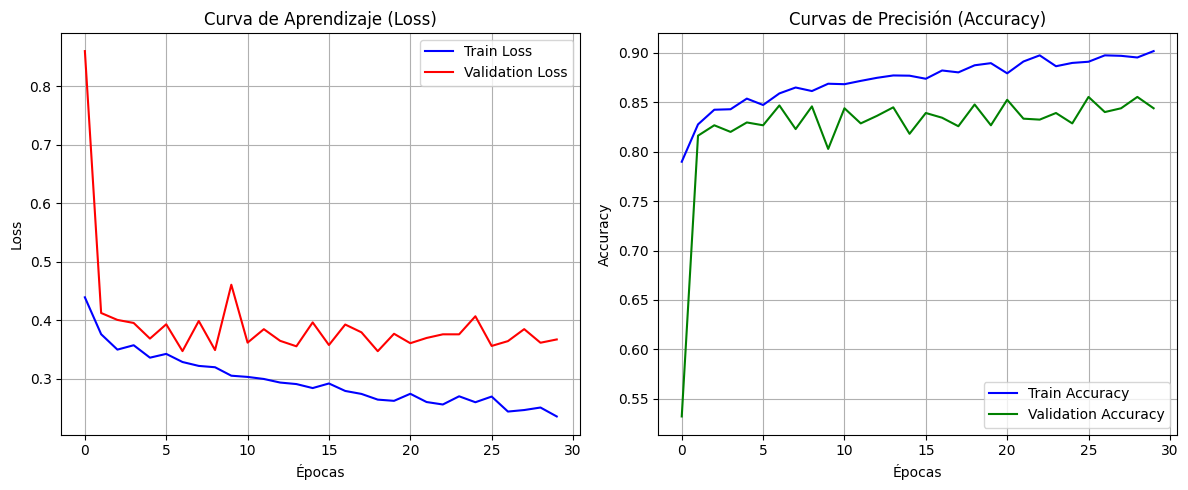

In [14]:
import matplotlib.pyplot as plt

# Crear una figura con dos gráficas (Loss y Accuracy)
plt.figure(figsize=(12, 5))

# --- GRÁFICA 1: PÉRDIDA (LOSS) ---
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.title('Curva de Aprendizaje (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- GRÁFICA 2: PRECISIÓN (ACCURACY) ---
plt.subplot(1, 2, 2)
# AHORA SÍ pintamos ambas curvas
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')   # <--- NUEVA LÍNEA
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Curvas de Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()